In [1]:
import tarfile
import matplotlib.pyplot as plt
from pathlib import Path
from dysh.util.download import from_url
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.util.selection import Selection
from dysh.spectra.core import average
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation, t
import astropy.units as u
from RegscorePy import bic
from collections.abc import Sequence


In [2]:
path_to_raw_vegas = f"/home/sdfits/AGBT24B_251_02/AGBT24B_251_02.raw.vegas/" 
sdfits = GBTFITSLoad(path_to_raw_vegas, backend="VEGAS")

Flags were created from existing flag files. Use GBTFITSLoad.flags.show() to see them.


In [3]:
sdfits.flags.show()

 ID TAG OBJECT BANDWID DATE-OBS ... SUBOBSMODE FITSINDEX CHAN UTC # SELECTED
--- --- ------ ------- -------- ... ---------- --------- ---- --- ----------


In [5]:
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,6,BC22,801.0,OnOff,1,1.420406,1.420406,1,2,61,1,97.59854,21.908178
1,7,BC22,801.0,OnOff,2,1.420406,1.420406,1,2,61,1,99.79335,21.73278
2,8,BC22,801.0,OnOff,1,1.420406,1.420406,1,2,61,1,99.39169,23.975813
3,9,BC22,801.0,OnOff,2,1.420406,1.420406,1,2,61,1,100.781647,23.593848
4,10,BC22,801.0,OnOff,1,1.420406,1.420406,1,2,61,1,101.231538,26.036336
5,11,BC22,801.0,OnOff,2,1.420406,1.420406,1,2,61,1,102.421806,25.077636
6,12,BC22,801.0,OnOff,1,1.420406,1.420406,1,2,61,1,103.146221,28.109582
7,13,BC22,801.0,OnOff,2,1.420406,1.420406,1,2,61,1,104.875261,27.198765
8,14,BC22,801.0,OnOff,1,1.420406,1.420406,1,2,61,1,105.11463,30.160391
9,15,BC22,801.0,OnOff,2,1.420406,1.420406,1,2,61,1,106.438223,28.726869


In [6]:
BC22_scans =[18,20,22,24,26,28]  #[6, 8, 10, 12, 14, 16] #  # #

In [7]:
# Initialize lists and arrays to store flag channels, median flux, and MAD flux values
flag_list = []
median_flux_array = np.array([])
MAD_flux_array = np.array([])

# Iterate over each scan in BC22_scans
for scans in BC22_scans:
    # Load the spectra for the current scan
    Single_spectra1 = sdfits.getps(scan=scans, plnum=0)
    Single_spectra = Single_spectra1.timeaverage()
    flux_values = Single_spectra.flux.value  # Access flux values once

    # Calculate median flux and MAD flux for the current spectra
    median_flux = np.median(flux_values)
    median_flux_array = np.append(median_flux_array, median_flux)
    MAD_flux = median_abs_deviation(flux_values)
    MAD_flux_array = np.append(MAD_flux_array, MAD_flux)

    # Create a flag mask for values outside the median ± 5 * MAD range
    flag_mask = np.logical_or(flux_values < median_flux - 5 * MAD_flux,
                              flux_values > median_flux + 5 * MAD_flux)
    flag_chan = np.where(flag_mask)[0]

    # Define bounds and band for flagging
    lower_bound = 800
    upper_bound = 31000
    band = 5
    offsets = np.arange(-band, band + 1)

    # Filter valid flags within the bounds and create new_flag_chan using NumPy operations
    valid_flags = flag_chan[(flag_chan > lower_bound) & (flag_chan < upper_bound)]
    new_flag_chan = np.unique(np.concatenate([valid_flags + offset for offset in offsets] + 
                                             [np.array([i for i in range(0, lower_bound)])] + 
                                             [np.array([i for i in range(upper_bound, len(flux_values))])]))
    new_flag_chan = [int(i) for i in new_flag_chan if i >= 0 and i < len(flux_values)]
    print(f"{scans} number, flags:", new_flag_chan)

    # Flag the channels in the current scan
    sdfits.flag(scan=scans, channel=new_flag_chan, plnum=0)

    # Check if scans+1 is within a valid range before flagging
    if scans + 1 <= max(BC22_scans):
        sdfits.flag(scan=scans + 1, channel=new_flag_chan, plnum=0)

    # Append the new_flag_chan to the flag_list
    flag_list.append(new_flag_chan)

18 number, flags: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 2

In [10]:
sdfits.flags.show()

 ID    TAG    SCAN PLNUM               CHAN               # SELECTED
--- --------- ---- ----- -------------------------------- ----------
  0 ab2abc0ef   18     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  1 4f31b7ae9   19     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
 10 fb9df4a0e   28     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  2 64f432349   20     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  3 64717fbb3   21     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  4 58160666c   22     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  5 5e71c3b49   23     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  6 540cd3694   24     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  7 3fd60a9ee   25     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  8 6d450f106   26     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  9 489514f4a   27     0 [0,1,2,3,4,5,6,...5,32766,32767]        122


In [ ]:
median_flux_array, MAD_flux_array

(array([0.2388866 , 0.34618376, 0.22273678, 0.26196078, 0.26839557,
        0.20994313]),
 array([0.04018869, 0.04211153, 0.04347188, 0.0398615 , 0.04247252,
        0.03996534]))

In [33]:
index_to_drop = np.where(MAD_flux_array > 5*np.mean(MAD_flux_array))[0]
if index_to_drop.size > 0:  # Check if index_to_drop is not empty
	BC22_scans = [scan for i, scan in enumerate(BC22_scans) if i not in index_to_drop]

INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]


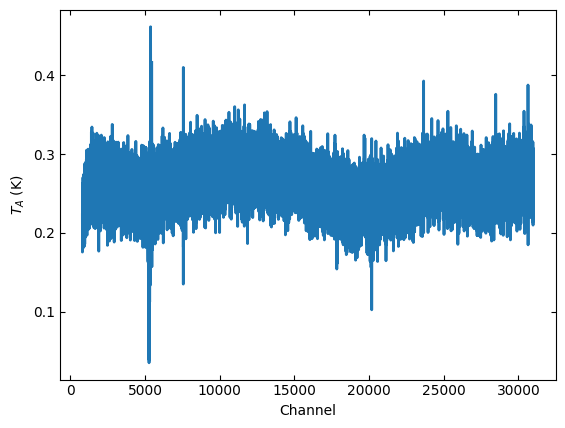

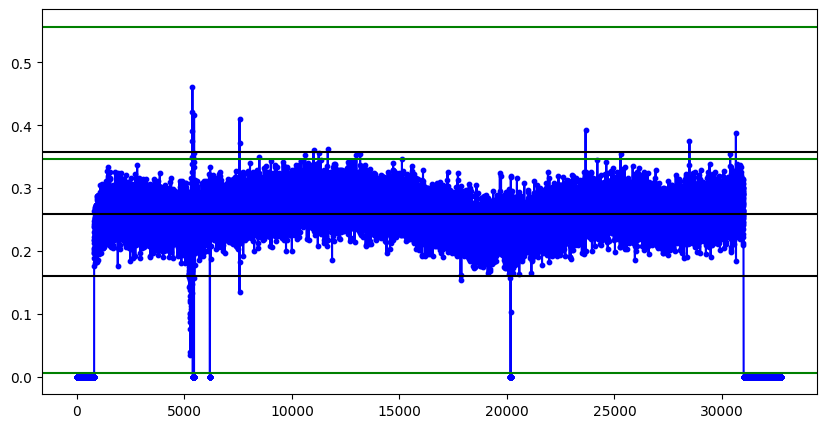

In [46]:
ps_scanblock = sdfits.getps(scan=BC22_scans, plnum=0, apply_flags=True)
ps = ps_scanblock.timeaverage()
ps.plot(xaxis_unit="chan")
fig,ax = plt.subplots(figsize=(10,5))

ax.scatter(range(0, len(ps.flux.value)),ps.flux.value, color='b', s=10)
ax.plot(ps.flux.value, color='b')

ax.axhline(np.median(ps.flux.value), color='k')
ax.axhline(np.median(ps.flux.value) - 5*median_abs_deviation(ps.flux.value), color='k')
ax.axhline(np.median(ps.flux.value)+ 5*median_abs_deviation(ps.flux.value), color='k')


ax.axhline(max(median_flux_array), color='g')
ax.axhline(min(median_flux_array - 5*MAD_flux_array), color='g')
ax.axhline(max(median_flux_array+ 5*MAD_flux_array), color='g')

INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]


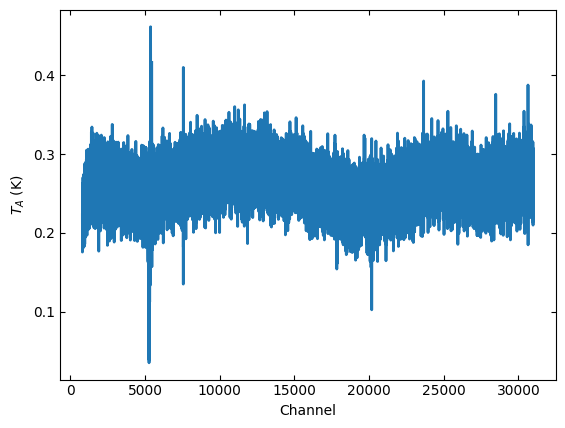

In [12]:
# Load the spectra for the current scan
flagged_spectra1 = sdfits.getps(scan=BC22_scans, plnum=0)
flagged_spectra = flagged_spectra1.timeaverage()
flagged_spectra.plot(xaxis_unit="chan")
flagged_flux_values = flagged_spectra.flux.value 


In [34]:

# Calculate median flux and MAD flux for the current spectra
fmedian_flux = np.median(flagged_flux_values)
fMAD_flux = median_abs_deviation(flagged_flux_values)


# Create a mask for values within the median ± 3 * MAD range
mask = np.logical_and(flagged_flux_values > fmedian_flux - 5 * fMAD_flux,
                        flagged_flux_values < fmedian_flux + 5 * fMAD_flux)
exclude_mask = np.logical_or(flagged_flux_values < fmedian_flux - 5 * fMAD_flux,
                        flagged_flux_values > fmedian_flux + 5 * fMAD_flux)
exclude_chan = np.where(exclude_mask)[0]
mask_chan = np.where(mask)[0]


In [35]:
fmedian_flux, fMAD_flux

(np.float64(0.25839116077769975), np.float64(0.01974584904466152))

In [36]:
flagged_flux_values[mask_chan]

array([0.22310429, 0.21802799, 0.20049154, ..., 0.27678052, 0.22263353,
       0.23488634], shape=(30054,))

In [83]:
# check if there is 0 in the flagged_flux_values
print(np.where(flagged_flux_values[mask_chan] == np.nan)[0])


[]


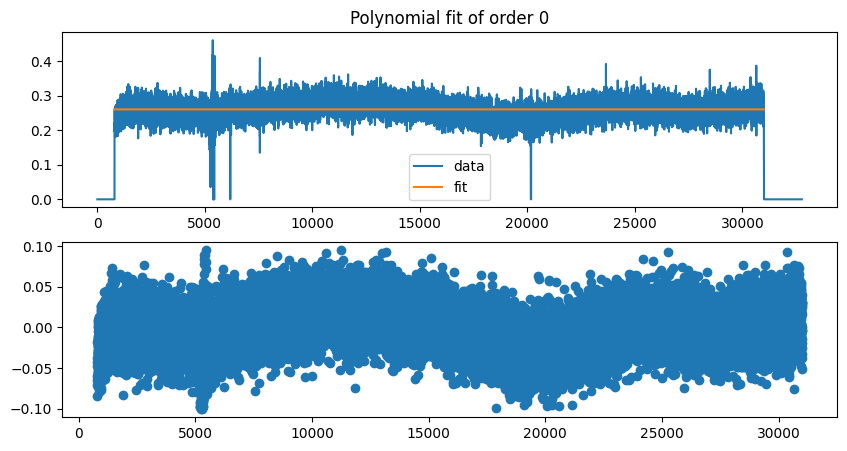

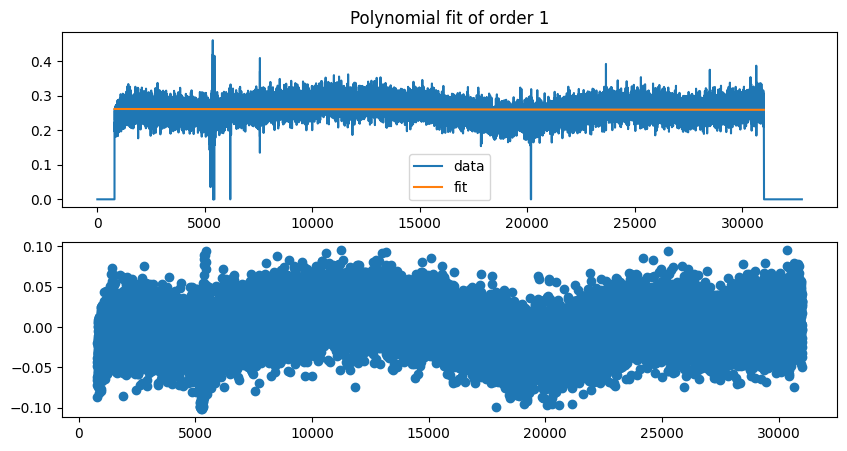

Order: 1, BIC: -218550.64, ΔBIC: -9.93


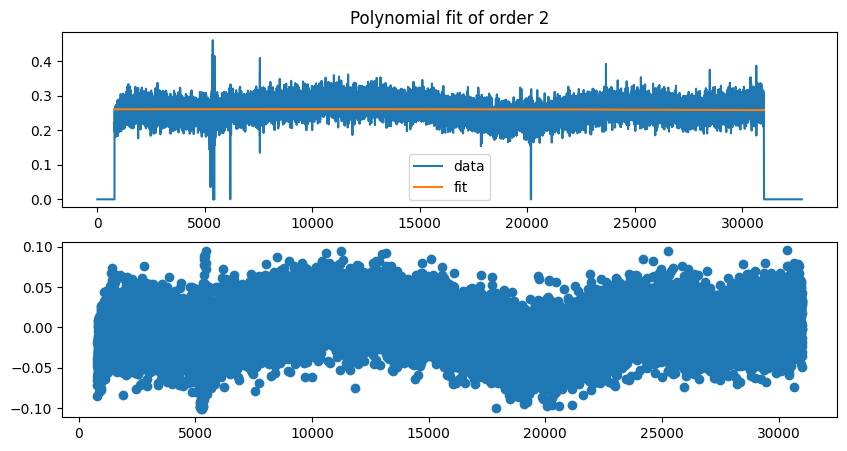

Order: 2, BIC: -218547.79, ΔBIC: 2.84


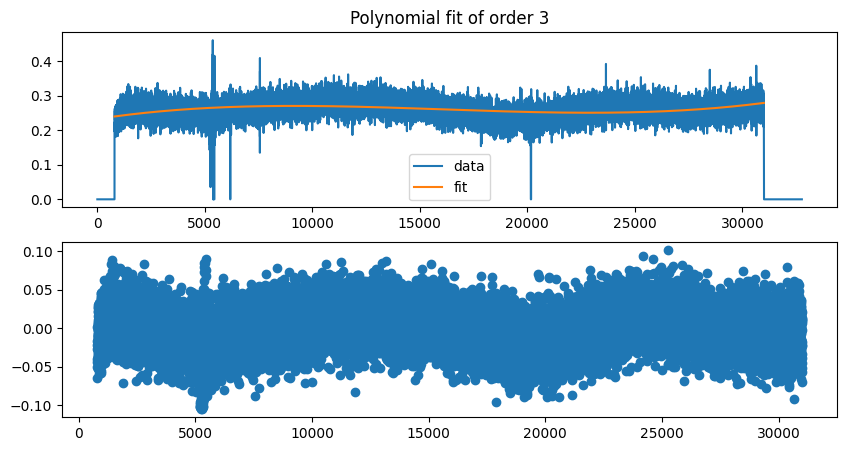

Order: 3, BIC: -221370.02, ΔBIC: -2822.23


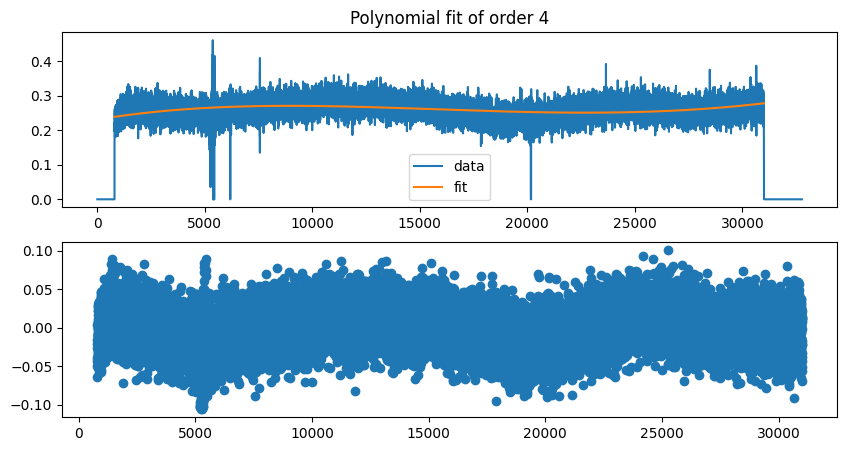

Order: 4, BIC: -221365.75, ΔBIC: 4.27


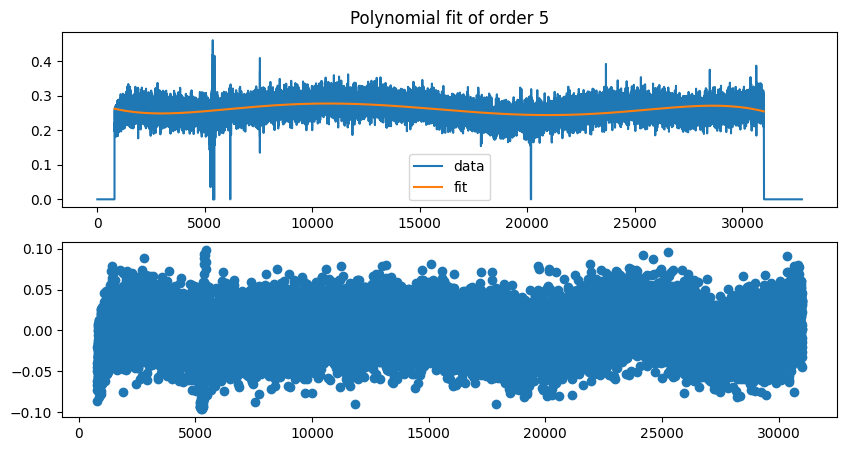

Order: 5, BIC: -223869.54, ΔBIC: -2503.79


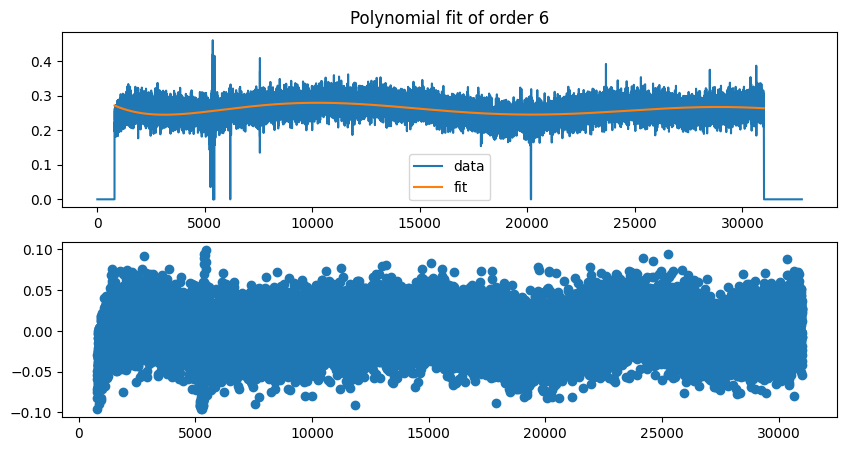

Order: 6, BIC: -224197.27, ΔBIC: -327.72


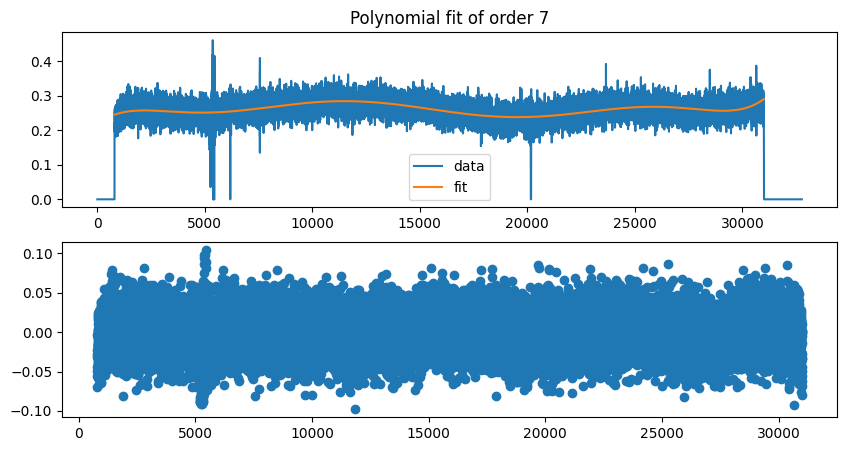

Order: 7, BIC: -226797.09, ΔBIC: -2599.82


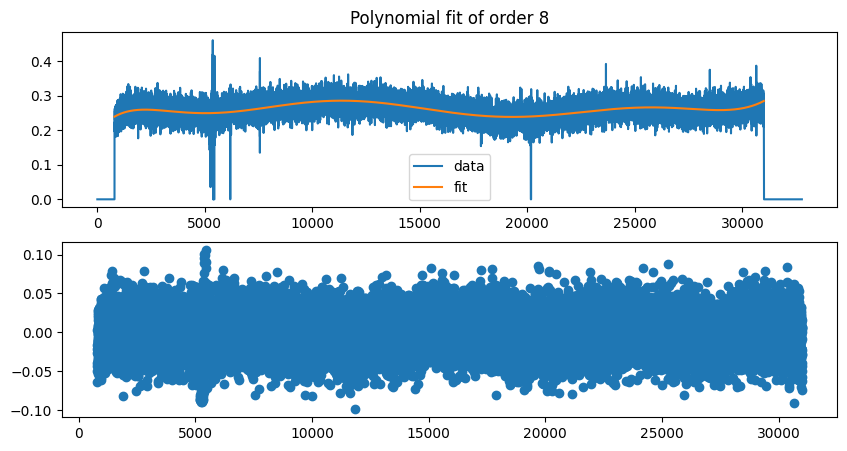

Order: 8, BIC: -226893.59, ΔBIC: -96.51


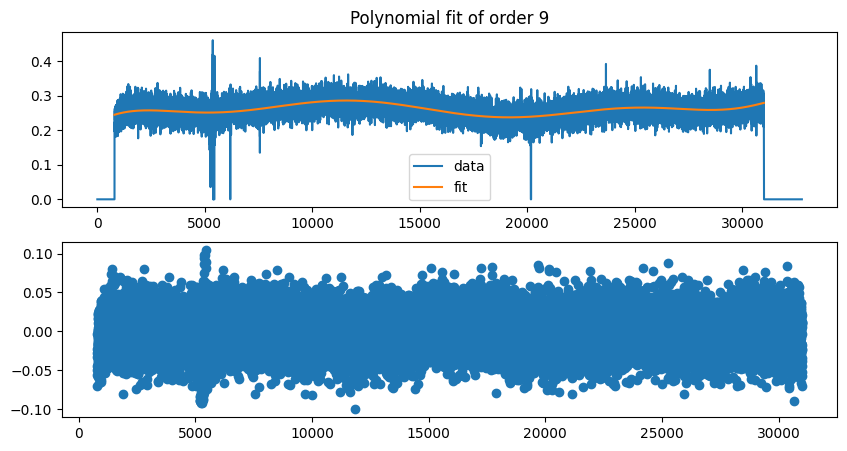

Order: 9, BIC: -226975.49, ΔBIC: -81.89


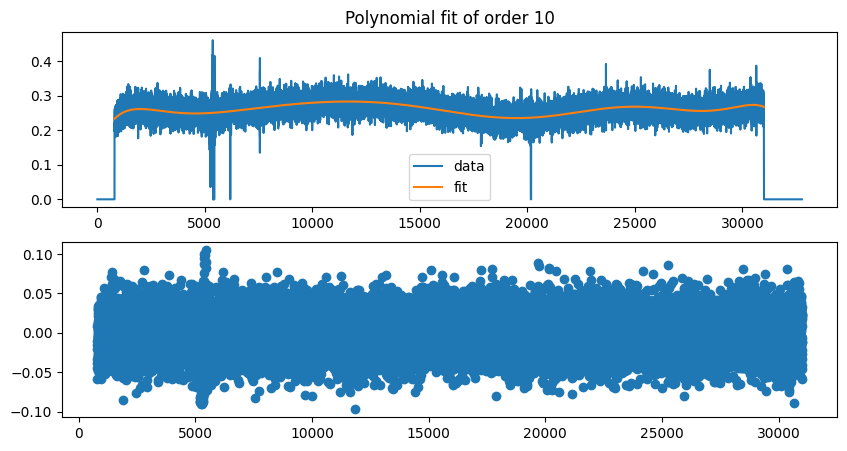

Order: 10, BIC: -227338.79, ΔBIC: -363.31


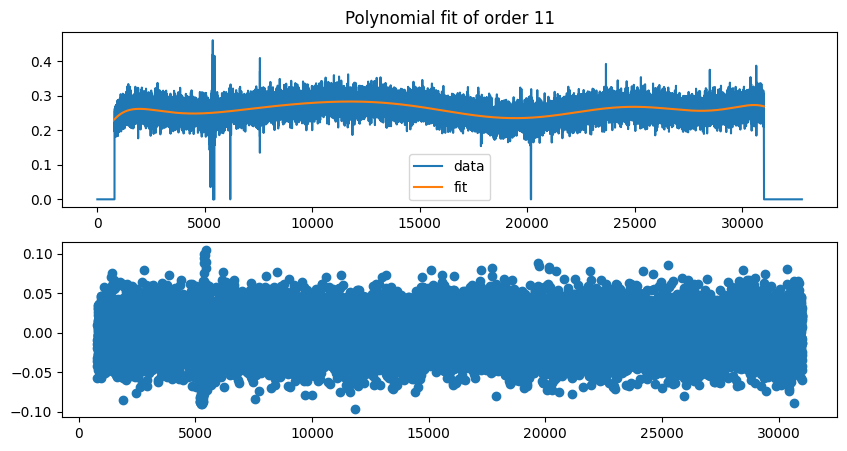

Order: 11, BIC: -227334.12, ΔBIC: 4.67


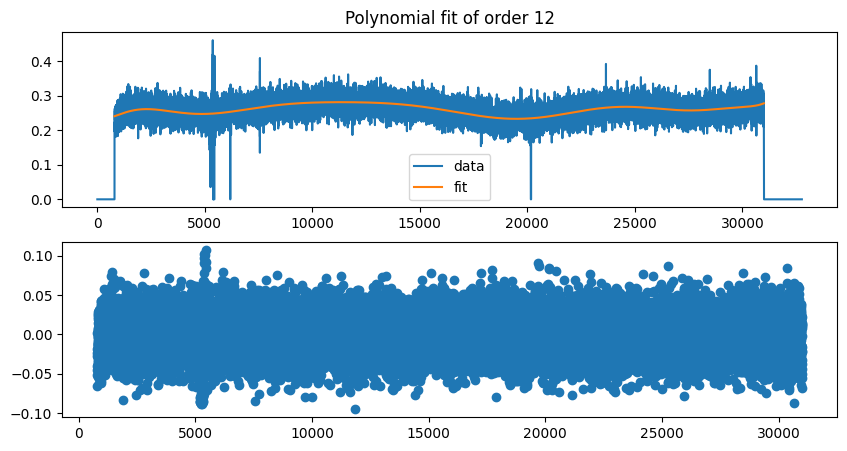

Order: 12, BIC: -227508.15, ΔBIC: -174.03


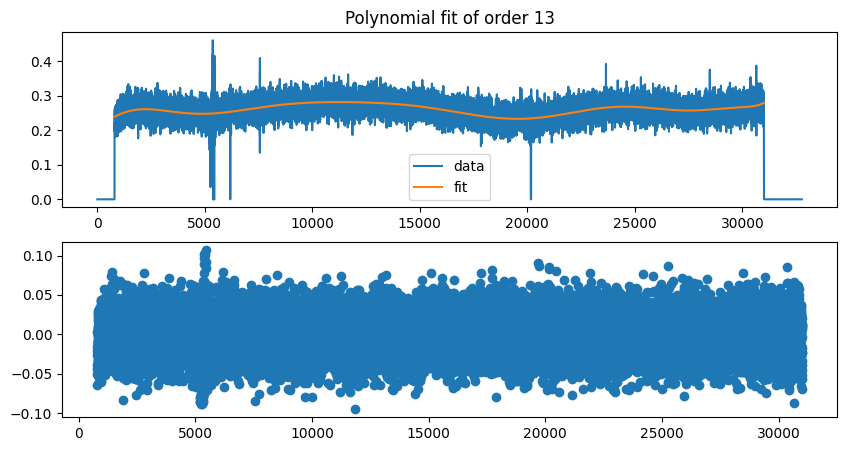

Order: 13, BIC: -227502.74, ΔBIC: 5.41


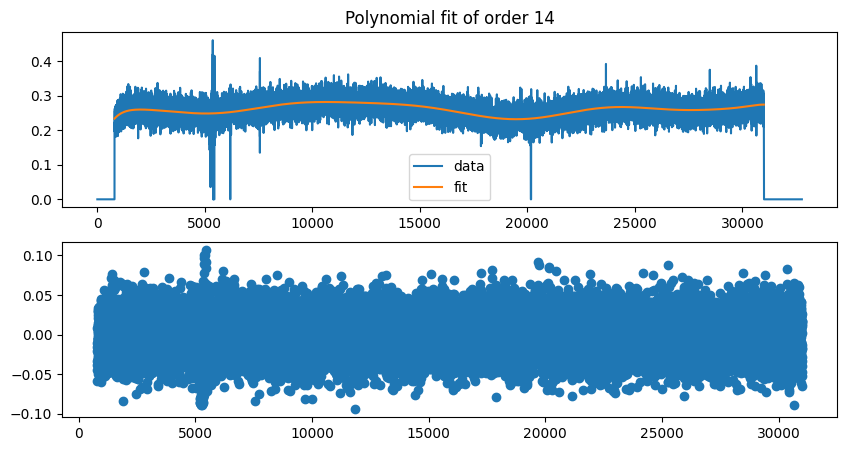

Order: 14, BIC: -227549.65, ΔBIC: -46.91


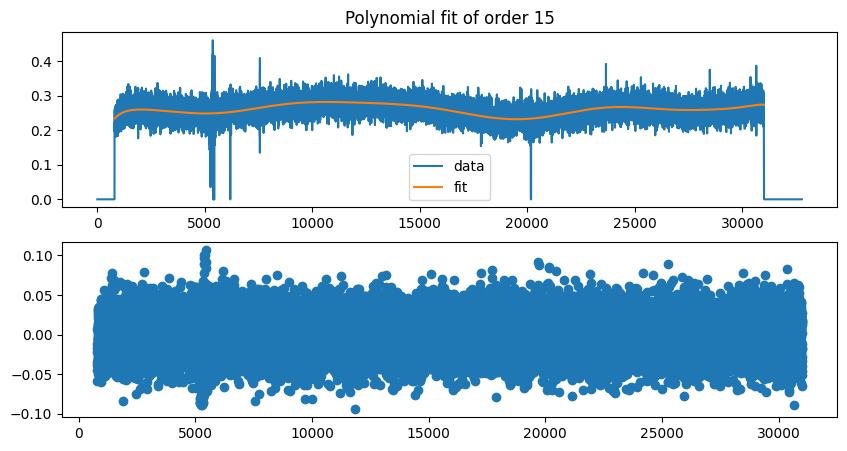

Order: 15, BIC: -227539.57, ΔBIC: 10.08


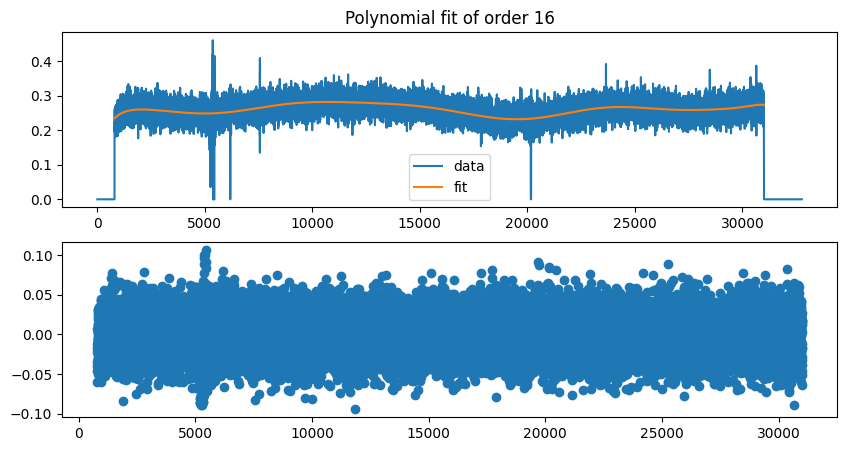

Order: 16, BIC: -227528.80, ΔBIC: 10.77


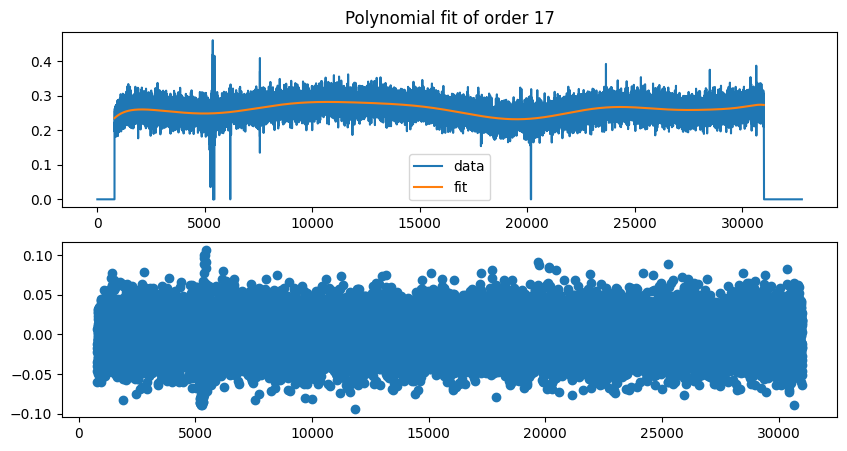

Order: 17, BIC: -227517.75, ΔBIC: 11.05


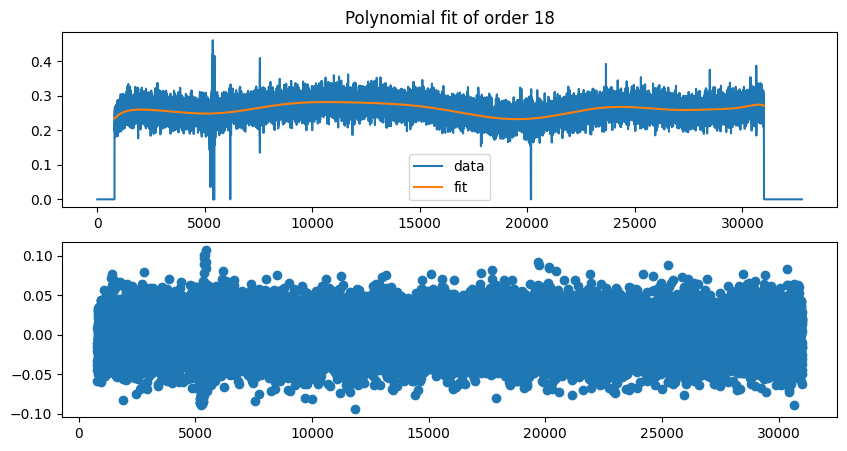

Order: 18, BIC: -227511.80, ΔBIC: 5.95


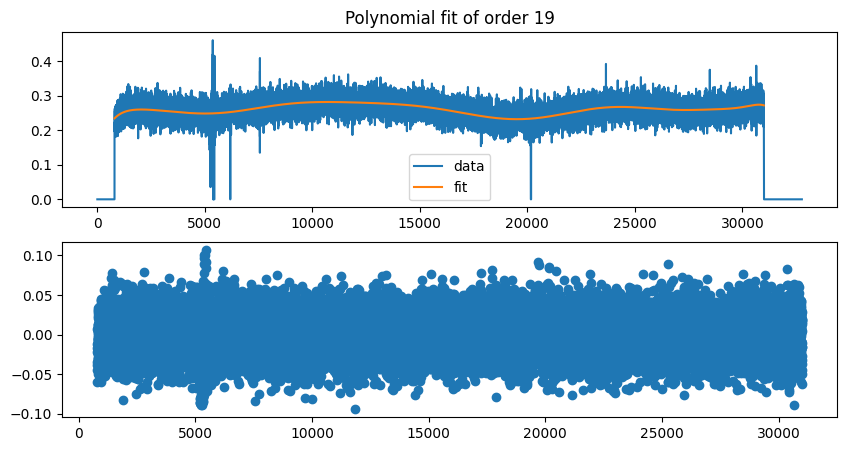

Order: 19, BIC: -227498.41, ΔBIC: 13.39
Recommended polynomial order (BIC): 14


In [40]:
best_order_bic = 0
best_bic = float('inf')

n = len(mask_chan)  # Number of data points
del_bic = []
bic_list = []

for i in range(0, 20):
    order = i
    coeff, residuals, _, _, _ = np.polyfit(mask_chan, flagged_flux_values[mask_chan], deg=order, full=True)

    # Plot both the fit and residuals
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    ax[0].plot(range(0, len(flagged_flux_values)), flagged_flux_values, label='data')
    ax[0].plot(mask_chan, np.polyval(coeff, mask_chan), label='fit')
    ax[1].plot(mask_chan, flagged_flux_values[mask_chan] - np.polyval(coeff, mask_chan), 'o')
    ax[0].set_title(f"Polynomial fit of order {order}")
    ax[0].legend()
    plt.show()

    rss = residuals[0] if len(residuals) > 0 else np.sum((flagged_flux_values[mask_chan] - np.polyval(coeff, mask_chan))**2)
    k = order + 1  # Number of parameters

    # Manually calculate BIC
    bic = n * np.log(rss / n) + k * np.log(n)
    bic_list.append(bic)

    if bic < best_bic:
        best_bic = bic
        best_order_bic = order

    if i > 0:
        delta_bic = bic - bic_list[i-1]
        del_bic.append(delta_bic)
        print(f"Order: {order}, BIC: {bic:.2f}, ΔBIC: {delta_bic:.2f}")

print(f"Recommended polynomial order (BIC): {best_order_bic}")


Order: 0, BIC: -218540.709
Order: 1, BIC: -218550.636
Order: 2, BIC: -218547.792
Order: 3, BIC: -221370.023
Order: 4, BIC: -221365.754
Order: 5, BIC: -223869.545
Order: 6, BIC: -224197.269
Order: 7, BIC: -226797.086
Order: 8, BIC: -226893.594
Order: 9, BIC: -226975.488
Order: 10, BIC: -227338.794
Order: 11, BIC: -227334.123
Order: 12, BIC: -227508.152
Order: 13, BIC: -227502.741
Order: 14, BIC: -227549.650
Order: 15, BIC: -227539.571
Order: 16, BIC: -227528.797
Order: 17, BIC: -227517.751
Early stopping: no improvement

Recommended polynomial order (BIC): 14


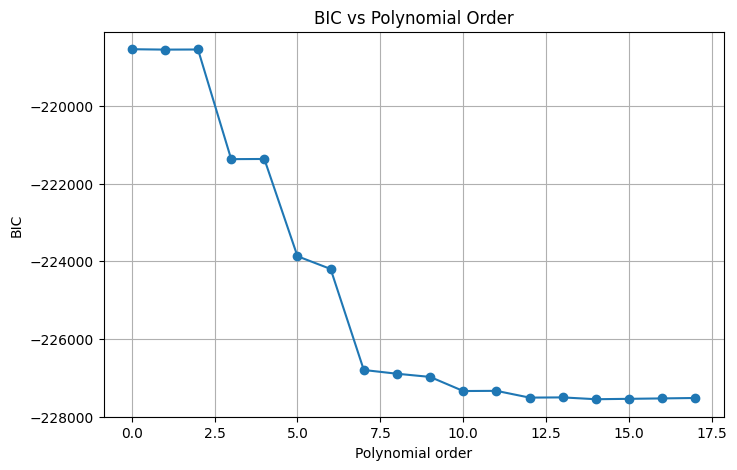

In [41]:
import numpy as np
import matplotlib.pyplot as plt

best_order_bic = 0
best_bic = float('inf')
patience = 3  # stop if no improvement for 3 orders
no_improve_counter = 0

n = len(mask_chan)  # Number of data points
bic_list = []

for i in range(0, 20):
    order = i
    coeff, residuals, _, _, _ = np.polyfit(mask_chan, flagged_flux_values[mask_chan], deg=order, full=True)

    rss = residuals[0] if len(residuals) > 0 else np.sum((flagged_flux_values[mask_chan] - np.polyval(coeff, mask_chan))**2)
    k = order + 1  # Number of parameters

    # Calculate BIC
    bic = n * np.log(rss / n) + k * np.log(n)
    bic_list.append(bic)

    if bic < best_bic - 1e-3:  # small threshold to avoid numerical noise
        best_bic = bic
        best_order_bic = order
        no_improve_counter = 0
    else:
        no_improve_counter += 1

    print(f"Order: {order}, BIC: {bic:.3f}")

    if no_improve_counter >= patience:
        print("Early stopping: no improvement")
        break

print(f"\nRecommended polynomial order (BIC): {best_order_bic}")

# Optional: final BIC vs order plot
plt.figure(figsize=(8, 5))
plt.plot(range(len(bic_list)), bic_list, marker='o')
plt.xlabel("Polynomial order")
plt.ylabel("BIC")
plt.title("BIC vs Polynomial Order")
plt.grid()
plt.show()


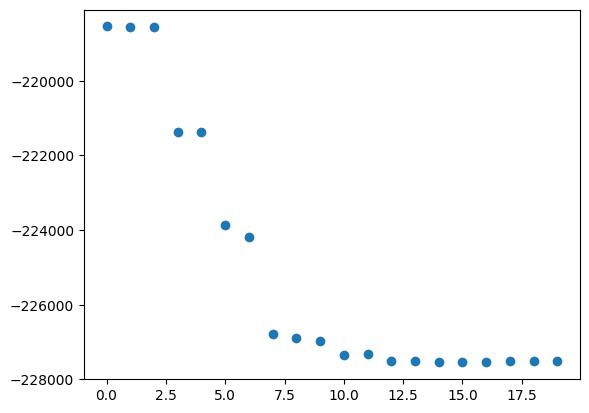

In [12]:
plt.scatter(range(0,len(bic_list),1), bic_list)

In [12]:
len(flagged_flux_values[mask_chan])

29275

In [13]:
mask_chan = list(mask_chan) 
mask_chan
exclude_chan = list(exclude_chan[lower_bound:upper_bound])
exclude_chan

[np.int64(803),
 np.int64(804),
 np.int64(807),
 np.int64(816),
 np.int64(818),
 np.int64(849),
 np.int64(856),
 np.int64(870),
 np.int64(925),
 np.int64(951),
 np.int64(960),
 np.int64(1016),
 np.int64(1109),
 np.int64(1403),
 np.int64(1441),
 np.int64(1450),
 np.int64(1519),
 np.int64(1769),
 np.int64(1886),
 np.int64(1899),
 np.int64(1902),
 np.int64(2070),
 np.int64(2265),
 np.int64(2479),
 np.int64(2618),
 np.int64(2705),
 np.int64(2716),
 np.int64(2801),
 np.int64(2933),
 np.int64(2947),
 np.int64(3406),
 np.int64(3411),
 np.int64(3531),
 np.int64(3776),
 np.int64(3852),
 np.int64(4014),
 np.int64(4298),
 np.int64(4363),
 np.int64(4481),
 np.int64(4679),
 np.int64(4725),
 np.int64(4835),
 np.int64(4856),
 np.int64(4904),
 np.int64(4916),
 np.int64(4934),
 np.int64(5007),
 np.int64(5045),
 np.int64(5140),
 np.int64(5157),
 np.int64(5158),
 np.int64(5165),
 np.int64(5174),
 np.int64(5179),
 np.int64(5184),
 np.int64(5194),
 np.int64(5196),
 np.int64(5199),
 np.int64(5203),
 np.int6

In [41]:
flag_freq = flagged_spectra.frequency.to(u.Hz)

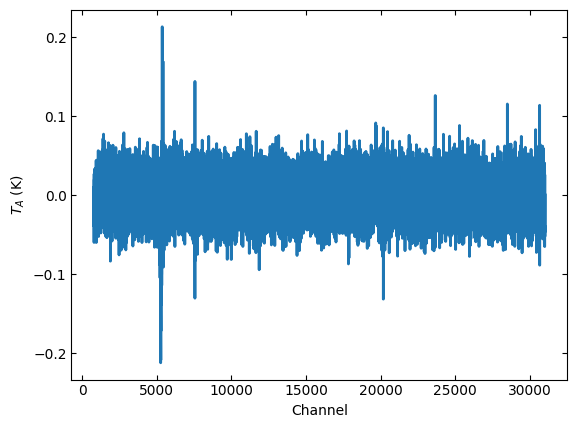

In [48]:
ps.baseline(model="poly", degree=14, remove=True)
ps.plot(xaxis_unit="chan")


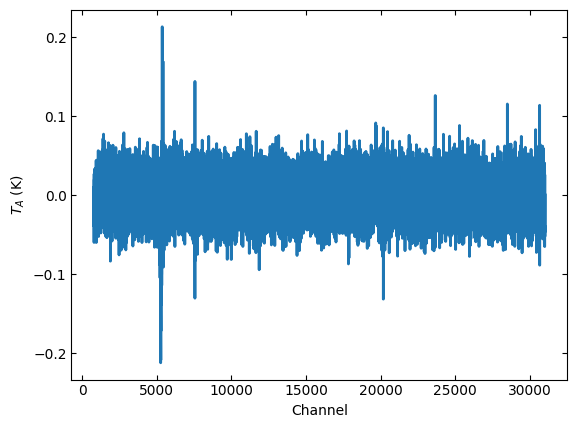

In [ ]:
flagged_spectra.baseline(model = 'poly', degree=best_order_bic, remove=True)
flagged_spectra.plot(xaxis_unit="chan")

In [49]:
smoothing = 5/(ps.velocity[3]-ps.velocity[2]).value

In [50]:
smoothing

np.float64(33.30815680378907)

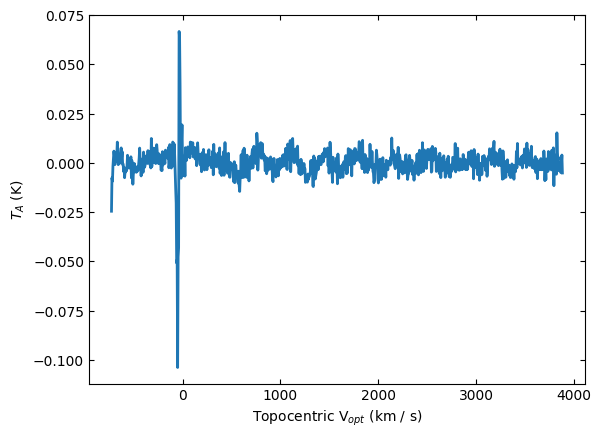

In [54]:
new_ps_smooth = ps.smooth('boxcar', int(smoothing))
new_ps_smooth.plot(xaxis_unit="km/s")


Adjusting decimation factor to be a natural number. Will decimate by 33


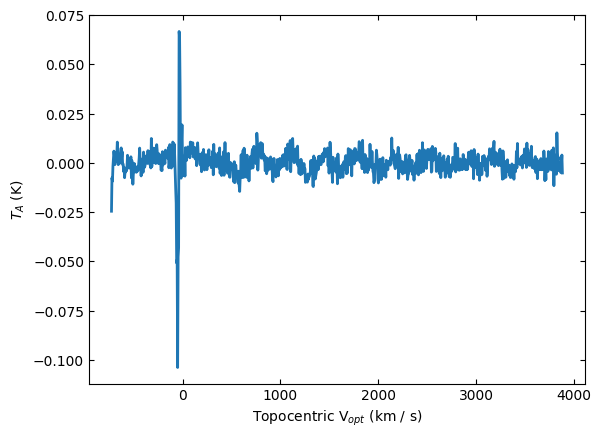

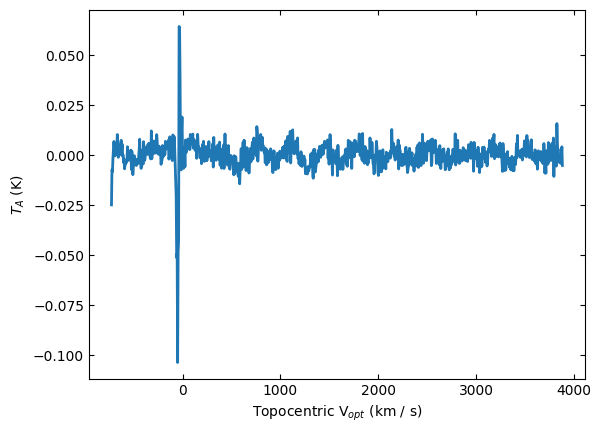

In [55]:
new_flagged_smooth = flagged_spectra.smooth('boxcar', smoothing)
new_ps_smooth.plot(xaxis_unit="km/s")
new_flagged_smooth.plot(xaxis_unit="km/s")